# Udacity Data Science Nanodegree Project 1 Term 2
## Write a Data Science Blog Post
### Seattle Airbnb Open Data

## Imports and own defined functions

In [1]:
# Packages
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [97]:
def char_eraser(string, character):
    """The functions takes a string, substracts the character passed as an argument and 
    returns the result as an int."""
    if pd.isna(string):
        value = np.nan
    else:
        value = float(string.replace(character, ''))
    
    return value

def price_converter(string):
    """The function takes a number formated as a string that ends with a dolar symbol ($) and erases the symbol. 
     the number has decimals delimited by a comma ',' it  
    """
    if isinstance(string, str):
        value = float(string.replace('$', '').replace(',', ''))
    else:
        value = string
    
    return value

def is_holidays(date):
    """Checks if the date is a Seattle holiday"""
    holidays_2016 = ['2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', 
                     '2016-11-11', '2016-11-24', '2016-11-25', '2016-12-26', '2017-01-01']
    
    if isinstance(date, pd.Timestamp):
        date = date.strftime('%Y-%m-%d')
    
    holiday = True if date in holidays_2016 else False
    
    return holiday

seasons = {1: 'Winter',
          2:'Spring',
          3:'Summer',
          4:'Fall'}
def get_season(date):
    """Maps to which season the date corresponds to."""
    if not isinstance(date, pd.datetime):
        date = pd.to_datetime(date)
        
    return seasons[date.quarter]

## Data Import

In [3]:
calendar = pd.read_csv('calendar_seattle.csv')
listings = pd.read_csv('listings_seattle.csv')

## Exploratory Data Analysis

In [4]:
print(calendar.shape, listings.shape)

(1393570, 4) (3818, 92)


In [5]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [6]:
len(calendar.dropna()['listing_id'].unique()) # number of different rooms

3723

In [7]:
calendar['date'].apply([np.min, np.max])

amin    2016-01-04
amax    2017-01-02
Name: date, dtype: object

In [8]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


## Preprocess

In [98]:
calendar['price'] = calendar['price'].apply(price_converter)  # Formating price column to number
calendar['available'] = calendar['available'].apply(lambda x: False if x == 'f' else True)  # Formating available column to boolean
calendar['date'] = pd.to_datetime(calendar['date']) # Formating date
calendar['month'] = calendar['date'].apply(lambda x: x.month)
calendar['season'] = calendar['date'].apply(get_season)
calendar['day'] = calendar['date'].apply(lambda x: x.day)
calendar['is_holiday'] = calendar['date'].apply(is_holidays) 
calendar['weekday'] = calendar['date'].apply(lambda x: x.day_name())
calendar['is_friday_saturday'] = calendar['weekday'].apply(lambda x: 
                                                    True if x in ['Friday', 'Saturday'] else False)

Percentage of missing values per column:

In [10]:
(len(calendar) - calendar.apply('count'))/len(calendar)*100

listing_id             0.000000
date                   0.000000
available              0.000000
price                 32.938998
month                  0.000000
day                    0.000000
is_holiday             0.000000
weekday                0.000000
is_friday_saturday     0.000000
dtype: float64

For our analysis we are going to focus on the listings that are available:

In [11]:
calendar.dropna(inplace=True)

In [12]:
# Creating a DataFrame with average reviews rating by id
listings_reviews = listings.groupby('id')[['review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                             'review_scores_value']].agg([np.mean]).reset_index()

In [13]:
listings_reviews.columns = ['id', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                        'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                        'review_scores_value']

In [14]:
listings_vars_to_merge = listings[['id', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 
                                   'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type']]

In [49]:
# Merging calendar DataFrame with listings and listing_reviews
df = pd.merge(calendar, listings_vars_to_merge, left_on='listing_id', right_on='id', how='left')
# df.drop(['available', 'id'], axis=1, inplace=True)
df = pd.merge(df, listings_reviews, left_on='listing_id', right_on='id')
df.drop(['available', 'id_x', 'id_y', 'is_friday_saturday'], axis=1, inplace=True)
df['bathrooms'] = np.around(df['bathrooms'])

In [16]:
df.shape

(934542, 16)

In [16]:
pd.set_option('display.max_columns', 500)

In [18]:
df.head()

,listing_id,date,price,month,day,is_holiday,weekday,is_friday_saturday,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type
0,241032,2016-01-04,85.0,1,4,False,Monday,False,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed
1,241032,2016-01-05,85.0,1,5,False,Tuesday,False,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed
2,241032,2016-01-13,85.0,1,13,False,Wednesday,False,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed
3,241032,2016-01-14,85.0,1,14,False,Thursday,False,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed
4,241032,2016-01-18,85.0,1,18,True,Monday,False,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed


In [19]:
(len(df) - df.apply('count'))/len(df)*100

listing_id                      0.000000
date                            0.000000
price                           0.000000
month                           0.000000
day                             0.000000
is_holiday                      0.000000
weekday                         0.000000
is_friday_saturday              0.000000
neighbourhood_group_cleansed    0.000000
property_type                   0.033064
room_type                       0.000000
accommodates                    0.000000
bathrooms                       0.513942
bedrooms                        0.214330
beds                            0.039057
bed_type                        0.000000
dtype: float64

In [51]:
df.dropna(inplace=True)

## Data Visualization

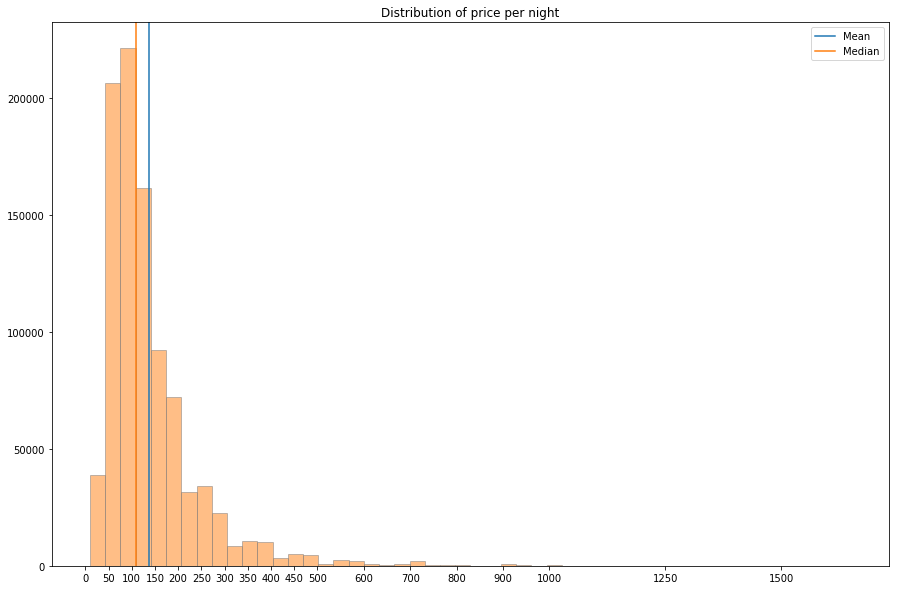

In [21]:
plt.figure(figsize=(15,10))
plt.hist(calendar['price'], bins=50, edgecolor='gray', color='C1', alpha=0.5)
plt.title('Distribution of price per night')
plt.xticks(list(range(0,501, 50)) + list(range(600,1001,100)) + [1250, 1500])
plt.axvline(x=calendar['price'].mean(), color='C0', label='Mean')
plt.axvline(x=calendar['price'].median(), color='C1', label='Median')
plt.legend()
plt.show()

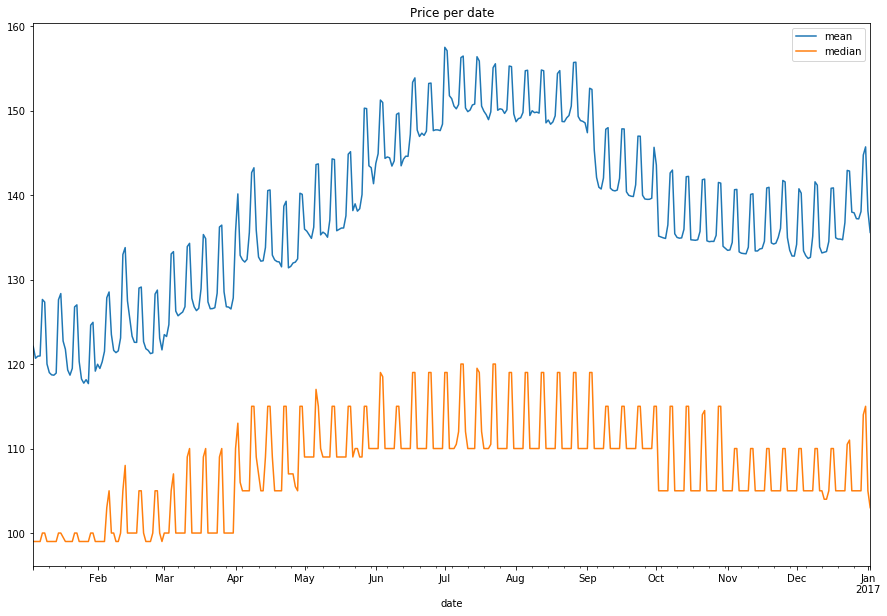

In [22]:
calendar.groupby('date')['price'].agg(['mean', 'median']).plot(figsize=(15,10),
                                                              title='Price per date')

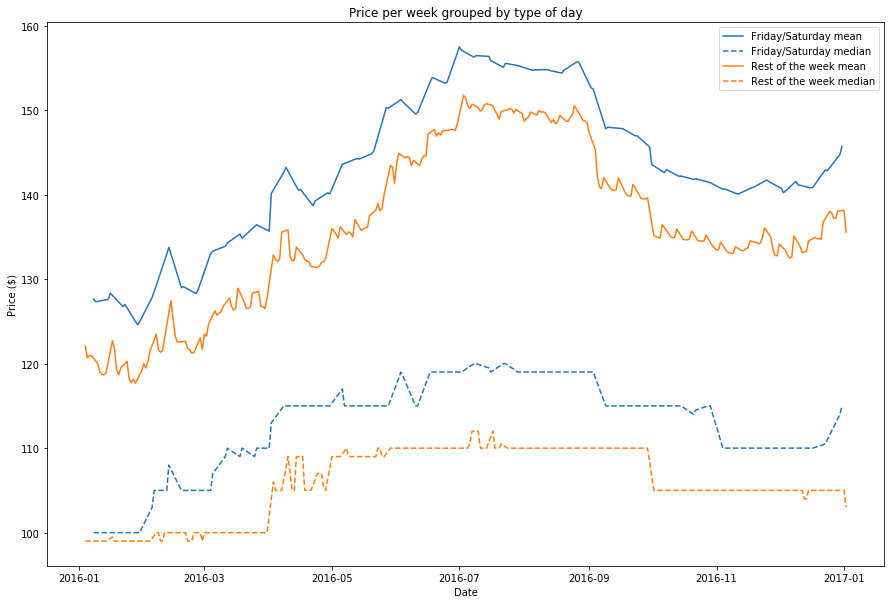

In [23]:
plt.figure(figsize=(15,10))
for pos, is_weekend in enumerate([True, False]):
    week_dict = {True: 'Friday/Saturday',
                False: 'Rest of the week'}
    filt = calendar[calendar['is_friday_saturday']  == is_weekend].groupby('date')['price'].agg(['mean', 'median'])
    plt.plot(filt.index, filt['mean'], color='C'+str(pos), label= week_dict[is_weekend] + ' mean')
    plt.plot(filt.index, filt['median'], color='C'+str(pos), linestyle='--', 
             label= week_dict[is_weekend] + ' median')
    plt.title('Price per week grouped by type of day')
    plt.ylabel('Price ($)')
    plt.xlabel('Date')
    plt.legend()
plt.show()

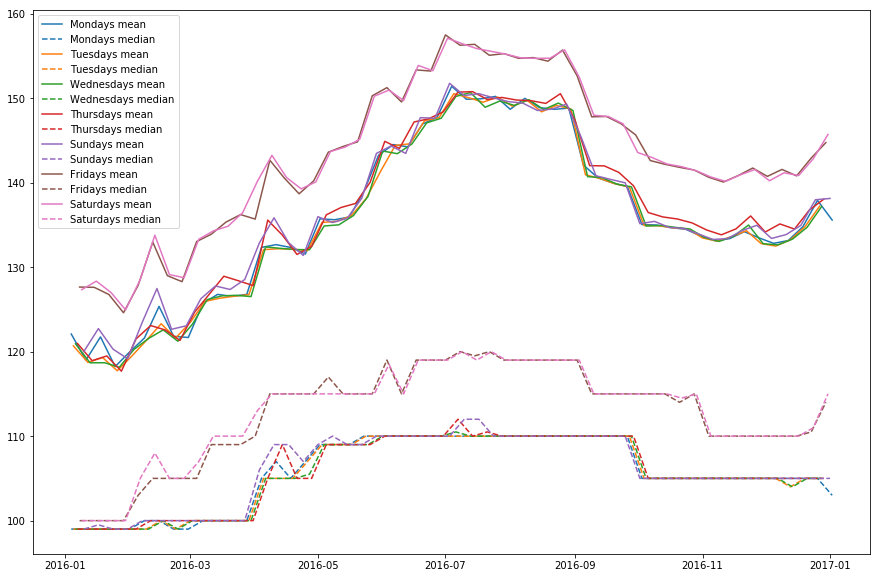

In [24]:
plt.figure(figsize=(15,10))
for pos, weekday in enumerate(calendar['weekday'].unique()):
    filt = calendar[calendar['weekday']  == weekday].groupby('date')['price'].agg(['mean', 'median'])
    plt.plot(filt.index, filt['mean'], color='C'+str(pos), label=weekday + 's mean')
    plt.plot(filt.index, filt['median'], color='C'+str(pos), linestyle='--', label=weekday + 's median')
    plt.legend()
plt.show()

## Modelling

In [21]:
df.columns

Index(['listing_id', 'date', 'price', 'month', 'day', 'is_holiday', 'weekday',
       'is_friday_saturday', 'neighbourhood_group_cleansed', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type'],
      dtype='object')

In [18]:
df[['month', 'day']] = df[['month', 'day']].astype('object')

In [52]:
X = df.iloc[:, 5:]
Y = df['price']

ohe = OneHotEncoder()
X = ohe.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

### Linear Regression

In [53]:
lm = LinearRegression()
lm.fit(X_train, Y_train)
Y_pred = lm.predict(X_test)
print(r2_score(Y_test, Y_pred))
print(np.sqrt(mean_squared_error(Y_test, Y_pred)))

0.6756705111148953
61.169603160285604


In [55]:
df['predicted_price'] = lm.predict(X)
df['error'] = df['price'] - df['predicted_price']
df['abs_error'] = np.abs(df['price'] - df['predicted_price'])

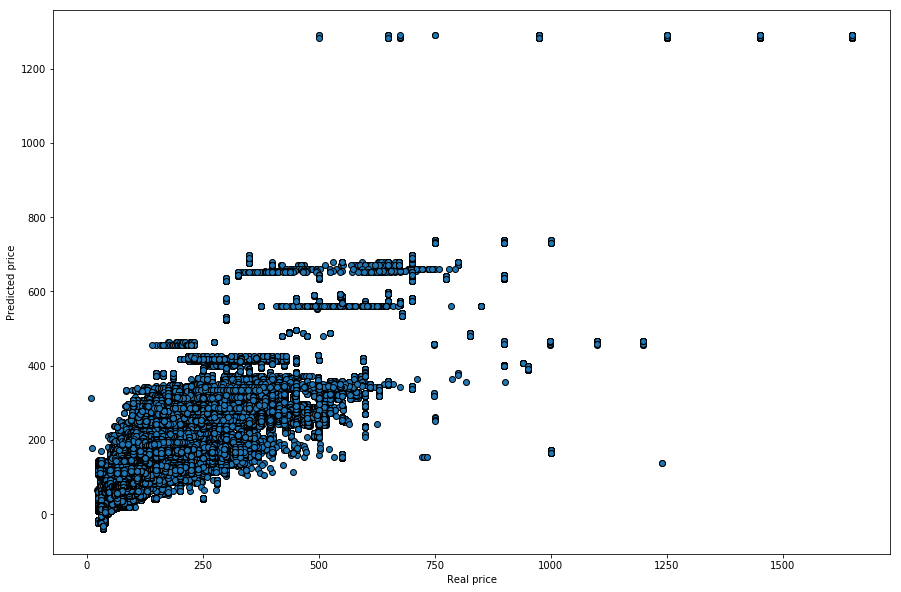

In [56]:
plt.figure(figsize=(15,10))
plt.scatter(df['price'], df['predicted_price'], edgecolors='black')
plt.xlabel('Real price')
plt.ylabel('Predicted price')
plt.show()

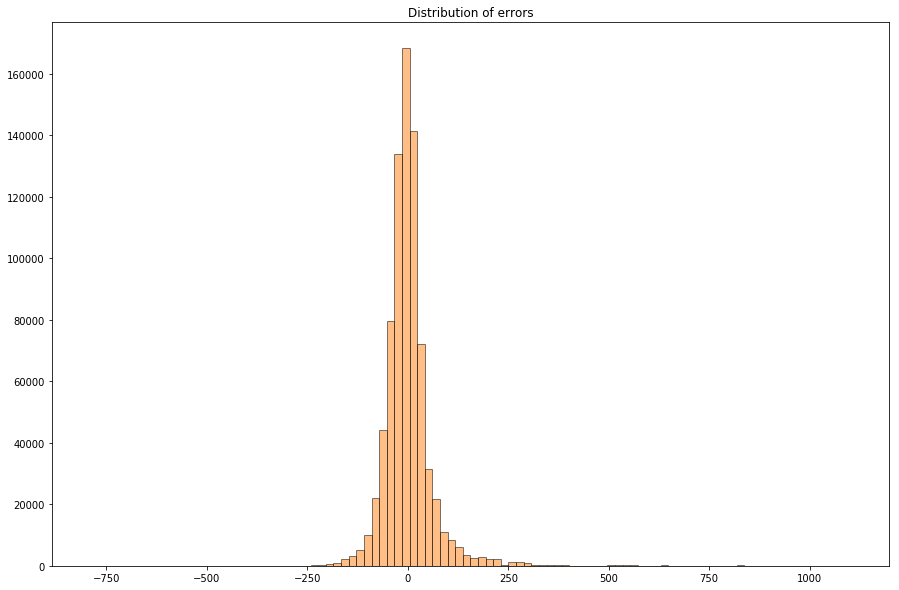

In [57]:
plt.figure(figsize=(15,10))
plt.hist(df['error'], bins = 100, edgecolor='black', color='C1', alpha=0.5)
plt.title('Distribution of errors')
plt.show()

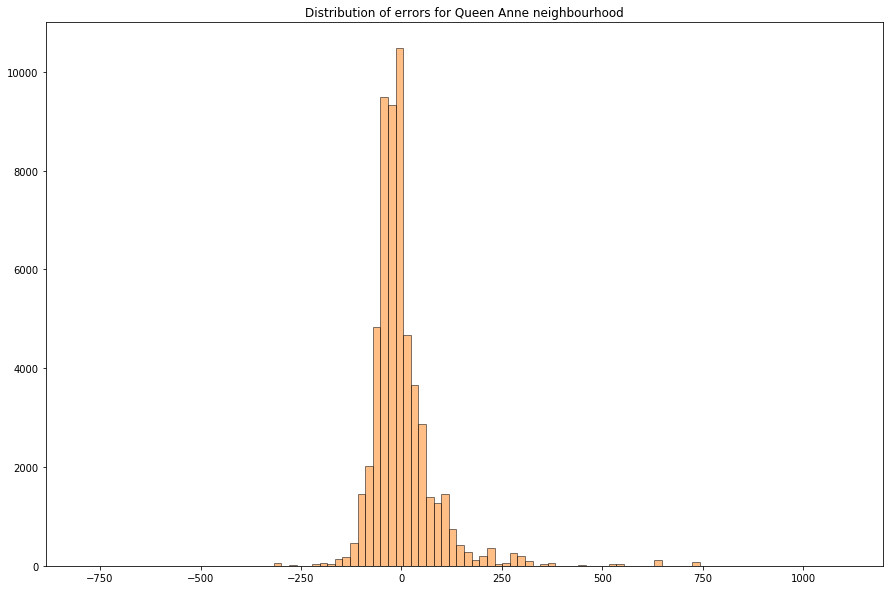

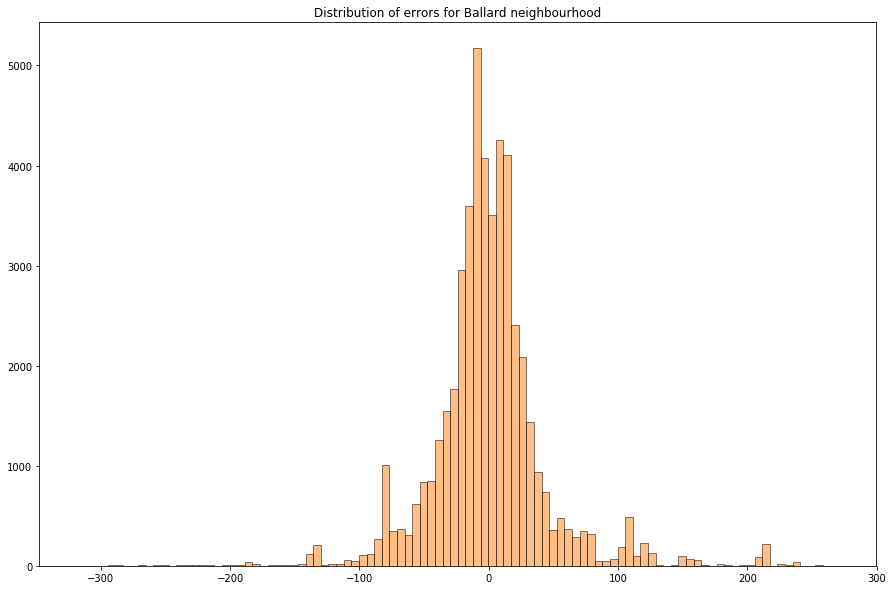

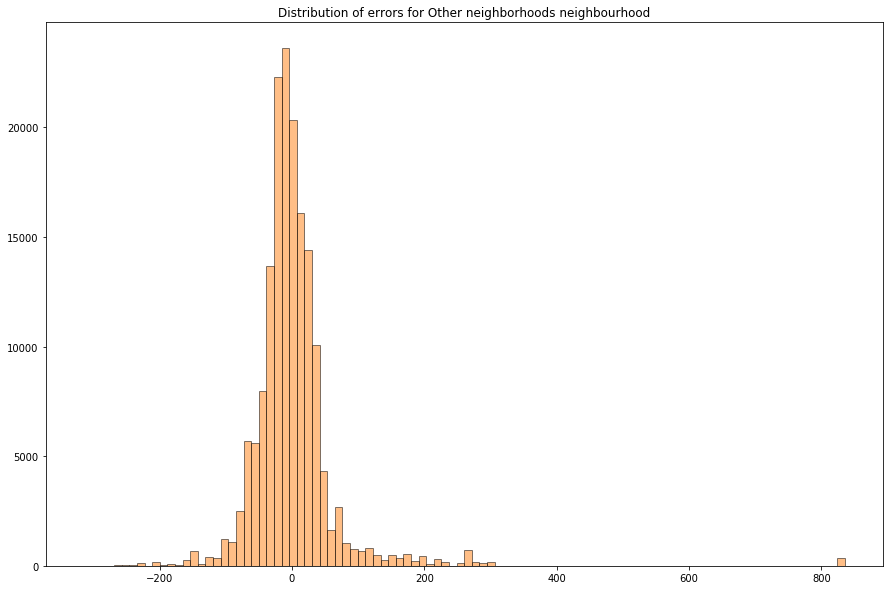

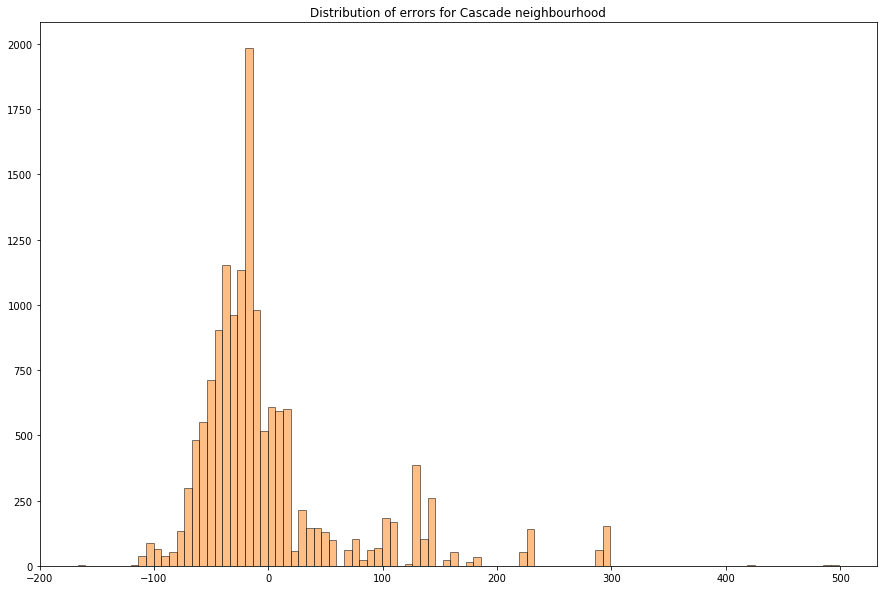

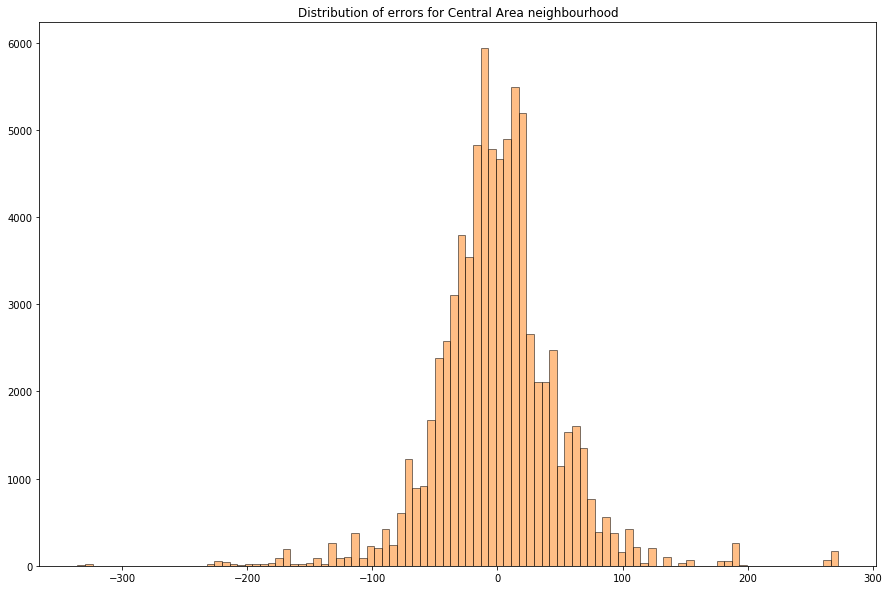

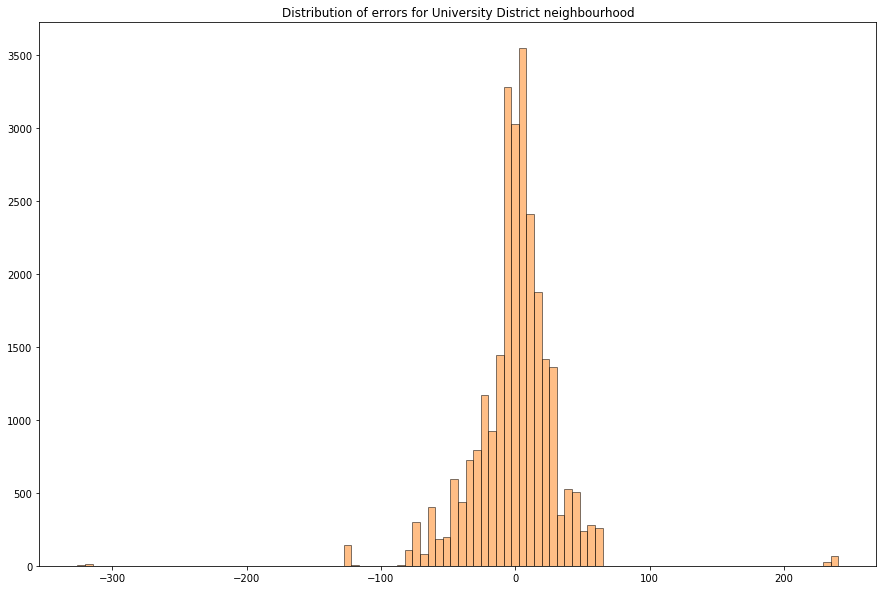

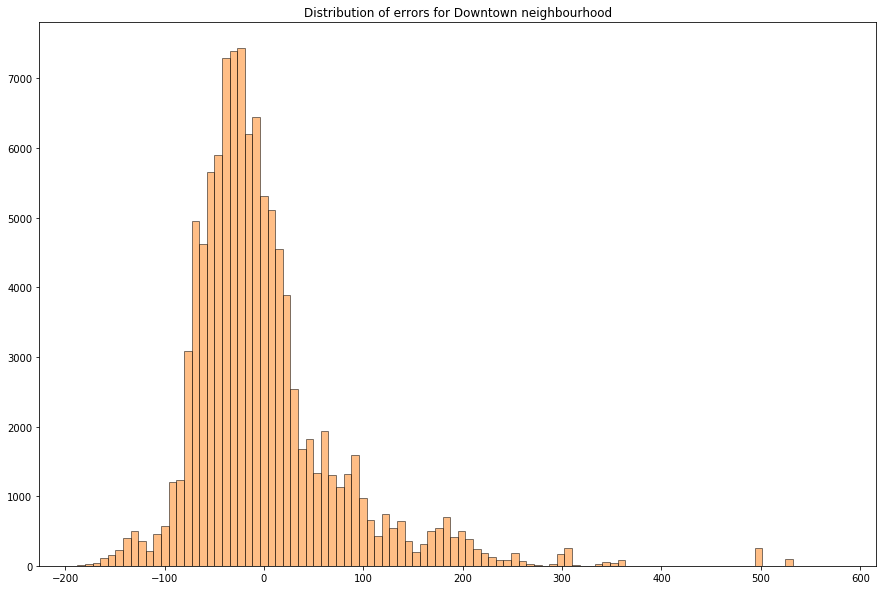

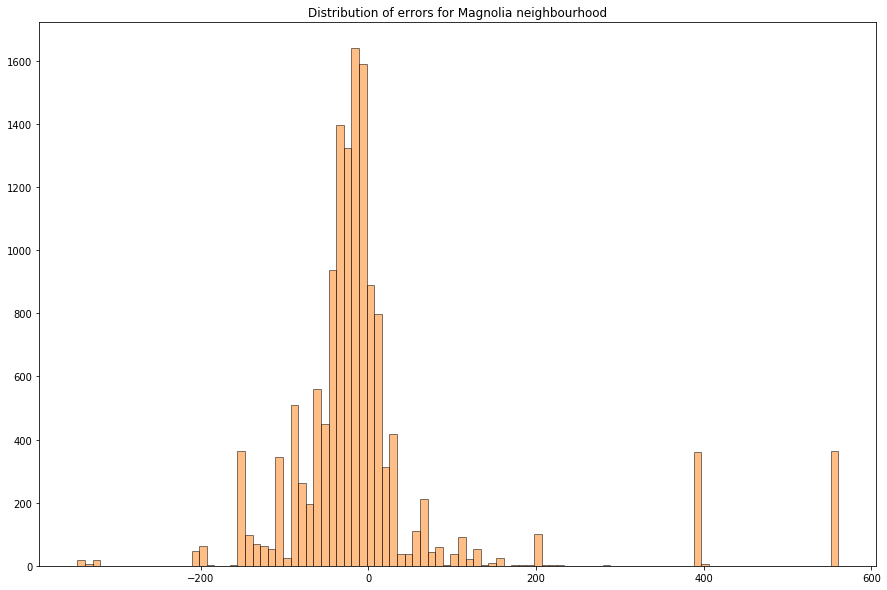

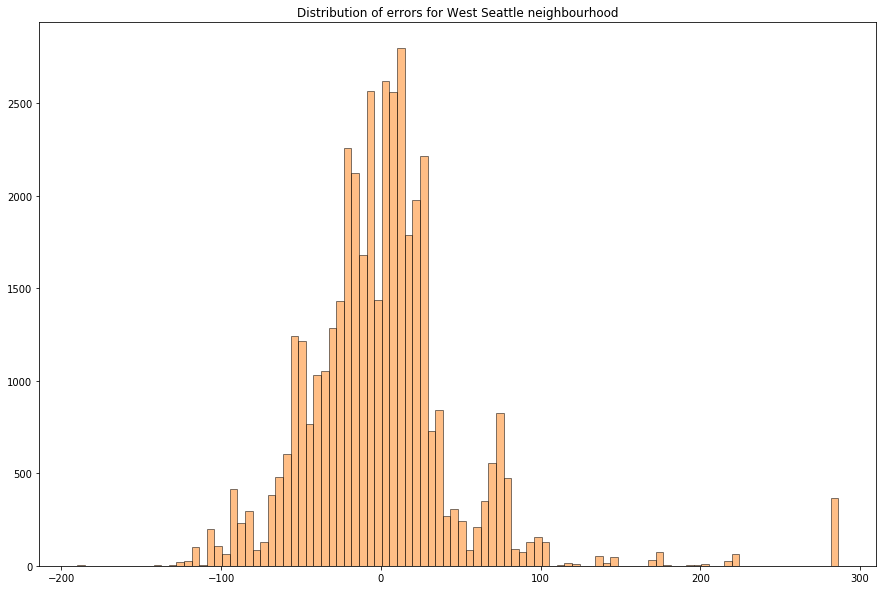

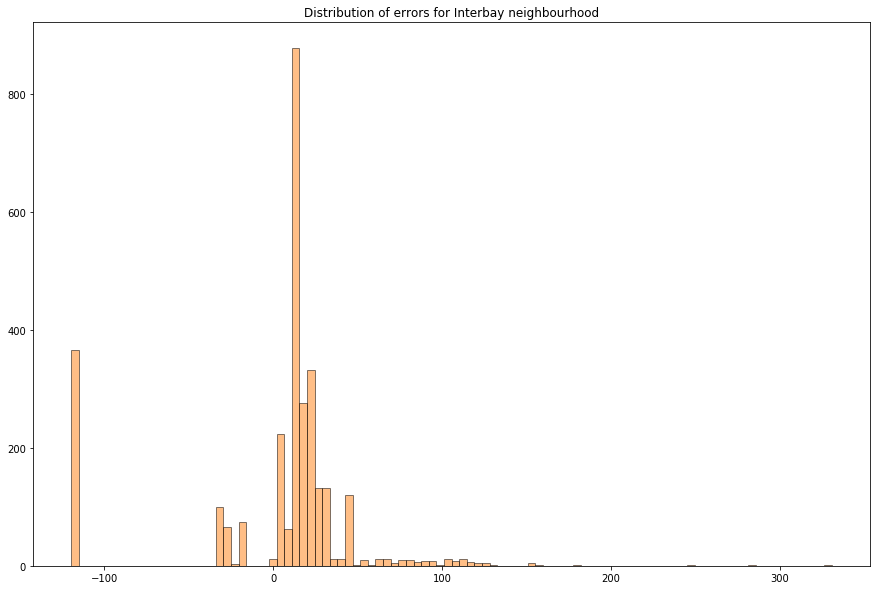

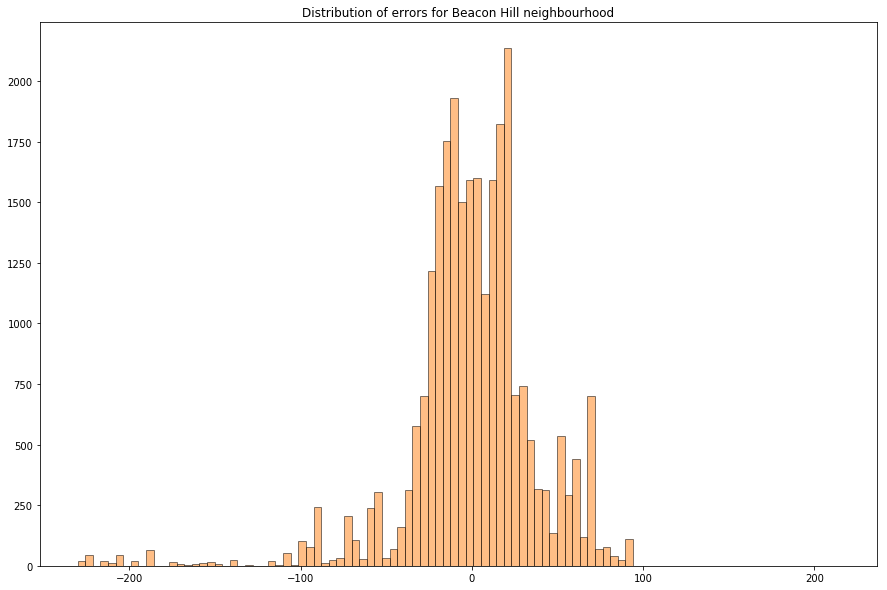

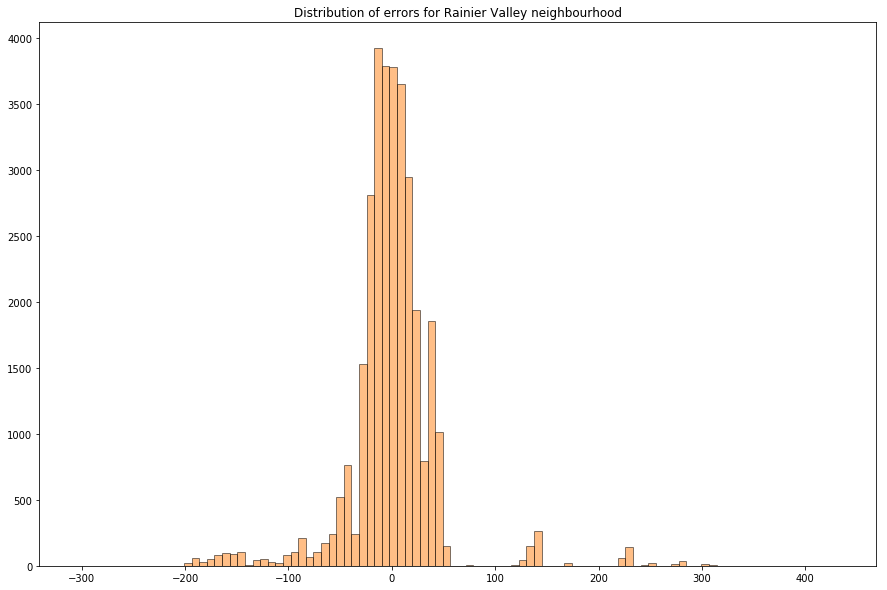

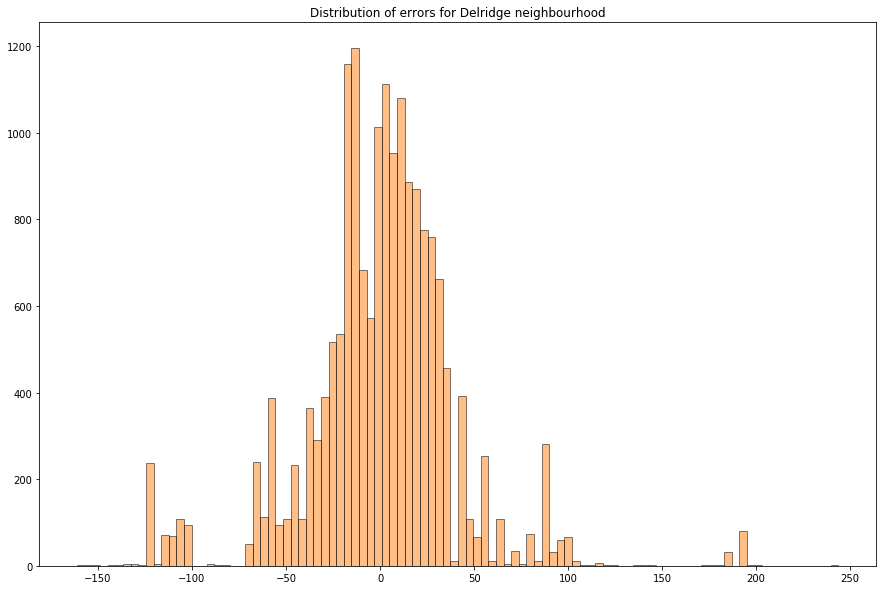

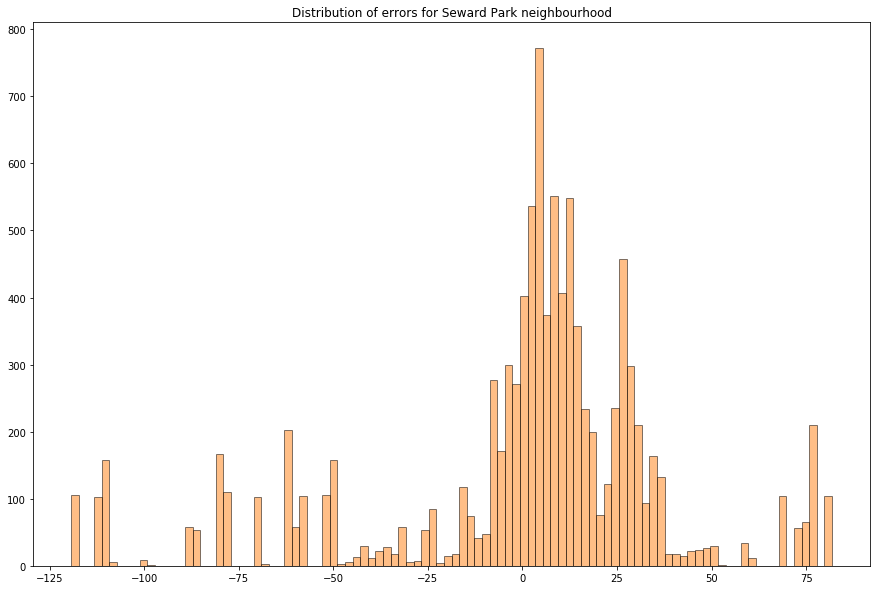

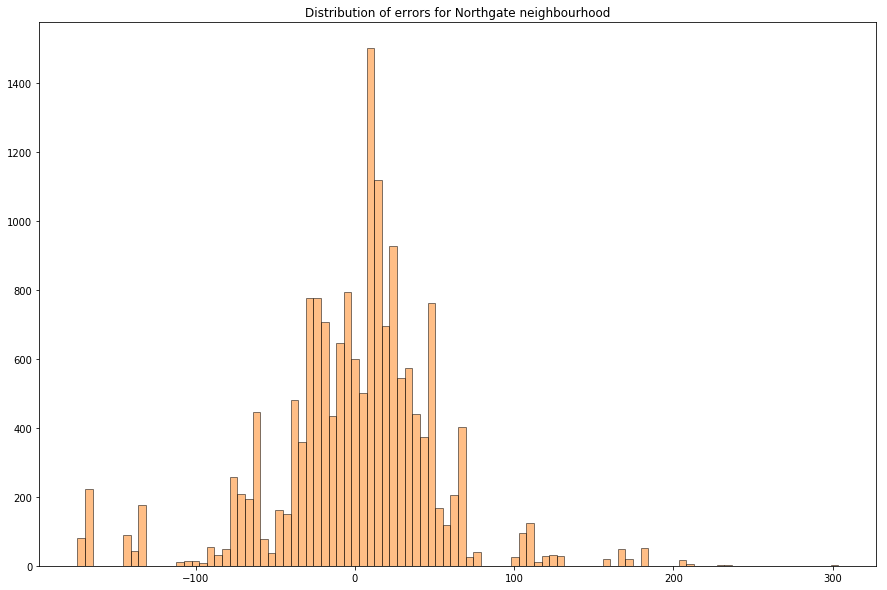

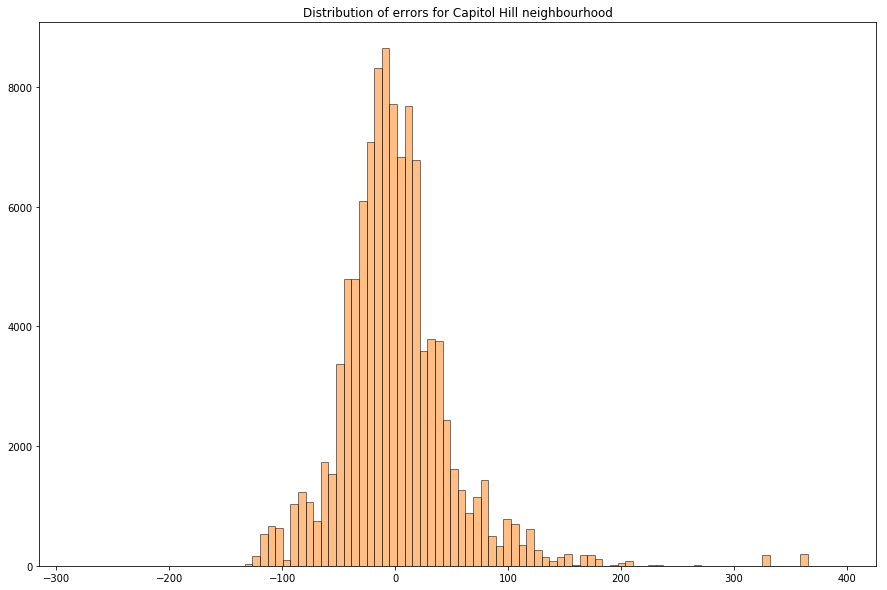

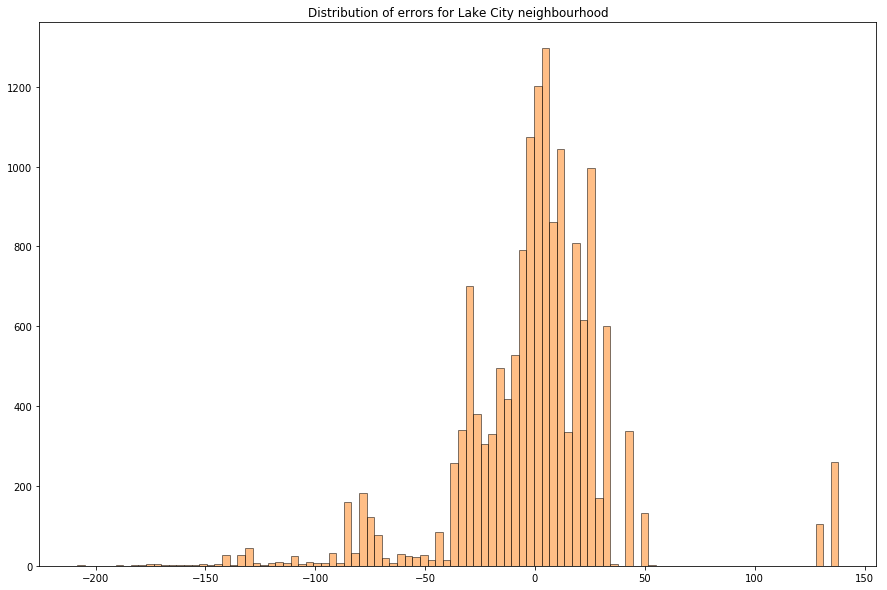

In [58]:
for neighbourhood in df['neighbourhood_group_cleansed'].unique():
    plt.figure(figsize=(15,10))
    filt = df[df['neighbourhood_group_cleansed']==neighbourhood]
    plt.hist(filt['error'], bins = 100, edgecolor='black', color='C1', alpha=0.5)
    plt.title('Distribution of errors for '+ neighbourhood + ' neighbourhood')
    plt.show()

In [59]:
df.groupby('neighbourhood_group_cleansed')['abs_error'].describe()

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group_cleansed,,,,,,,,
Ballard,49400.0,29.465686,34.162001,0.001011,9.204971,17.625450,35.578022,318.113516
Beacon Hill,26601.0,26.203238,28.308330,0.009201,10.109455,18.310576,30.628077,230.264782
Capitol Hill,106640.0,34.468006,36.113421,0.009186,11.553091,24.134241,44.244521,392.622628
Cascade,14653.0,46.826604,51.438183,0.011673,16.742467,31.013267,55.099557,498.522405
Central Area,78173.0,34.453656,34.723384,0.003278,11.780936,24.128738,46.416420,335.797440
Delridge,17884.0,27.941982,29.198548,0.001345,9.682356,18.593009,34.649370,243.830996
Downtown,107944.0,52.887518,55.808432,0.003315,18.866615,38.683277,67.480634,577.949939
Interbay,2940.0,34.934828,37.692162,1.085765,13.061082,18.571314,33.745347,330.870064
Lake City,15476.0,23.374870,28.016323,0.004377,6.118481,15.986499,28.495348,208.209217


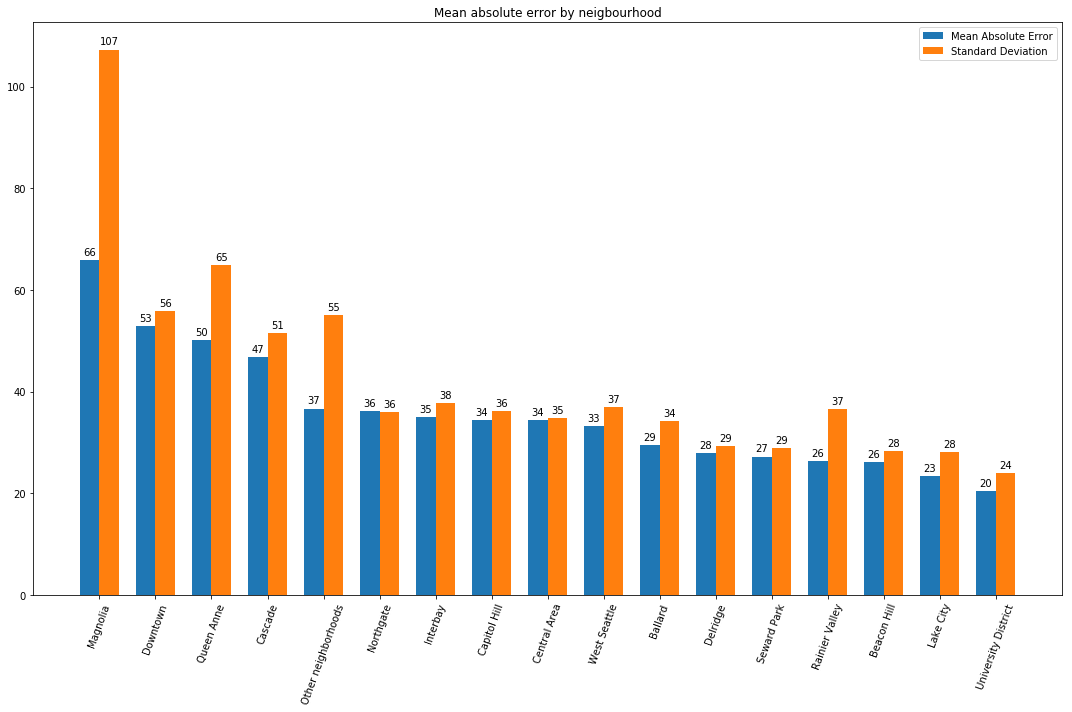

In [84]:
error_statistics_by_neighbourhood = df.groupby('neighbourhood_group_cleansed')['abs_error'].describe()
error_statistics_by_neighbourhood.sort_values('mean', ascending=False, inplace=True)

x = np.arange(len(error_statistics_by_neighbourhood))
width = 0.35

fig, ax = plt.subplots(figsize=(15,10))
rects1 = ax.bar(x - width/2, error_statistics_by_neighbourhood['mean'], width,
                label='Mean Absolute Error')
rects2 = ax.bar(x + width/2, error_statistics_by_neighbourhood['std'], width,
                label='Standard Deviation')

ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(error_statistics_by_neighbourhood.index, rotation=70)
ax.set_title('Mean absolute error by neigbourhood')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(int(np.around(height))),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [9]:
listings.loc[:,listings.columns.str.match('host')]

,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified
0,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t
1,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t
2,16708587,https://www.airbnb.com/users/show/16708587,Jill,2014-06-12,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,f,https://a1.muscache.com/ac/users/16708587/prof...,https://a1.muscache.com/ac/users/16708587/prof...,Queen Anne,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t
3,9851441,https://www.airbnb.com/users/show/9851441,Emily,2013-11-06,"Seattle, Washington, United States",NaN,NaN,NaN,NaN,f,https://a2.muscache.com/ac/users/9851441/profi...,https://a2.muscache.com/ac/users/9851441/profi...,Queen Anne,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t
4,1452570,https://www.airbnb.com/users/show/1452570,Emily,2011-11-29,"Seattle, Washington, United States","Hi, I live in Seattle, Washington but I'm orig...",within an hour,100%,NaN,f,https://a0.muscache.com/ac/users/1452570/profi...,https://a0.muscache.com/ac/users/1452570/profi...,Queen Anne,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t
5,326758,https://www.airbnb.com/users/show/326758,Andrew,2010-12-25,"Seattle, Washington, United States",I've been fortunate to have had many life expe...,NaN,NaN,NaN,f,https://a2.muscache.com/ac/users/326758/profil...,https://a2.muscache.com/ac/users/326758/profil...,Queen Anne,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t
6,2497928,https://www.airbnb.com/users/show/2497928,Gary And Beth,2012-05-30,"Seattle, Washington, United States",We have lived in the the Queen Anne neighborho...,within an hour,100%,100%,t,https://a0.muscache.com/ac/users/2497928/profi...,https://a0.muscache.com/ac/users/2497928/profi...,Queen Anne,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t
7,4016632,https://www.airbnb.com/users/show/4016632,Jean-Marc,2012-10-30,"Seattle, Washington, United States","I am a carpenter at heart , I love music , I p...",within an hour,100%,100%,t,https://a1.muscache.com/ac/users/4016632/profi...,https://a1.muscache.com/ac/users/4016632/profi...,Queen Anne,5.0,5.0,"['email', 'phone', 'facebook', 'google', 'link...",t,t
8,2166277,https://www.airbnb.com/users/show/2166277,Aliza,2012-04-18,"Seattle, Washington, United States","I'm a 35 year old professional from Seattle, W...",NaN,NaN,100%,f,https://a1.muscache.com/ac/users/2166277/profi...,https://a1.muscache.com/ac/users/2166277/profi...,Queen Anne,1.0,1.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t
9,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t


In [88]:
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].apply(lambda x: char_eraser(x, '%'))
listings['host_response_rate'] = listings['host_response_rate'].apply(lambda x: char_eraser(x, '%'))

In [89]:
listings.groupby('host_location')[['host_acceptance_rate', 'host_response_rate']].mean().sort_values('host_response_rate', ascending=False).dropna()

,host_acceptance_rate,host_response_rate
host_location,,
"Accra, Greater Accra, Ghana",100.0,100.000000
"San Diego, California, United States",100.0,100.000000
"Rome, Lazio, Italy",100.0,100.000000
"Quilcene, Washington, United States",100.0,100.000000
"Prescott Valley, Arizona, United States",100.0,100.000000
"Port Townsend, Washington, United States",100.0,100.000000
"Phoenix, Arizona, United States",100.0,100.000000
"Arlington, Massachusetts, United States",100.0,100.000000
"Long Beach, California, United States",100.0,100.000000
